# **From Random to Relevant:**  
## Predictive Modeling for Optimized Asset Assignment

This notebook dives into the key factors behind user conversions across Healthline’s digital assets, develops predictive models to improve asset assignment, and estimates potential revenue gains from more effective targeting approaches. The aim is to support real-time decisions that boost user engagement while maximizing monetization opportunities.

### **Import Libraries**

In [222]:
# Data manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.calibration import CalibratedClassifierCV

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Metrics and evaluation
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report
)

### **Load Dataset**

In [223]:
# Load the data
data = pd.read_excel('Case_Material.xlsx')

# Print first 5 rows
data.head()

,pageview_id,User ID,known_diagnosis,page_category,Device_Type,page_topic_description,session_start_time,asset_loaded_time,time of day,Return Visitor,Asset Shown,Conversion
0,14afd810-bee0-4dde-984a-f36e5082cc13,00007820-89cb-4c1d-9940-eb270d605a35,,nauseaandvomiting,tablet,abdominal_pain,45164.387613,45164.388195,9,0,B,0
1,264d4634-8b76-4043-aa6a-768225dba92b,00012b55-514c-421e-9c76-3300abbc1134,,nauseaandvomiting,mobile,abdominal_pain,45151.782681,45151.783348,18,0,B,0
2,8759fa0b-3596-4306-b46c-aa2303490211,000157c1-b6a3-4c86-82c7-9ec1bda3799a,Ulcerative Colitis,nauseaandvomiting,desktop,food_poisoning,45166.471808,45166.472273,11,0,A,0
3,287d4980-19be-4654-bdd0-344ab656bcc3,00020400-efab-4b10-8812-2a0aaf774841,,nauseaandvomiting,tablet,food_poisoning,45150.016442,45150.016804,0,1,A,0
4,4c6e84c5-448d-4211-a307-a1e26a34f8ea,0002f737-0cda-48fb-91ed-533f3d0eab05,,nauseaandvomiting,mobile,food_poisoning,45145.478711,45145.479199,11,0,A,0


### **Data Cleaning**

**Objectives:**
- Inspect data types & missing values
- Drop irrelevant identifiers
- Handle missing entries
- Convert timestamp columns to datetime

In [224]:
# Inspect data types and missing values
data.info()
data.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 12 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   pageview_id             100000 non-null  object 
 1   User ID                 100000 non-null  object 
 2   known_diagnosis         99858 non-null   object 
 3   page_category           100000 non-null  object 
 4   Device_Type             100000 non-null  object 
 5   page_topic_description  100000 non-null  object 
 6   session_start_time      100000 non-null  float64
 7   asset_loaded_time       100000 non-null  float64
 8   time of day             100000 non-null  int64  
 9   Return Visitor          100000 non-null  int64  
 10  Asset Shown             100000 non-null  object 
 11  Conversion              100000 non-null  int64  
dtypes: float64(2), int64(3), object(7)
memory usage: 9.2+ MB


pageview_id                 0
User ID                     0
known_diagnosis           142
page_category               0
Device_Type                 0
page_topic_description      0
session_start_time          0
asset_loaded_time           0
time of day                 0
Return Visitor              0
Asset Shown                 0
Conversion                  0
dtype: int64

In [225]:
# Drop irrelevant identifiers
data = data.drop(columns=['pageview_id', 'User ID'])

In [227]:
# Handle missing values
data['known_diagnosis'] = data['known_diagnosis'].fillna('Unknown')

# Strip whitespace from all known_diagnosis entries
data['known_diagnosis'] = data['known_diagnosis'].str.strip()

# Replace empty strings with "Unknown"
data['known_diagnosis'] = data['known_diagnosis'].replace('', 'Unknown')

In [228]:
# Verify
data['known_diagnosis'].value_counts(dropna=False)

known_diagnosis
Unknown               89019
Breast Cancer          3153
Ulcerative Colitis     2523
Depression             1864
Migraine               1786
Crohns Disease         1655
Name: count, dtype: int64

In [229]:
# Convert timestamp columns
data['session_start_time'] = pd.to_datetime('1899-12-30') + pd.to_timedelta(data['session_start_time'], unit='D')
data['asset_loaded_time'] = pd.to_datetime('1899-12-30') + pd.to_timedelta(data['asset_loaded_time'], unit='D')

In [230]:
# Confirm data is properly formatted
data.head()

,known_diagnosis,page_category,Device_Type,page_topic_description,session_start_time,asset_loaded_time,time of day,Return Visitor,Asset Shown,Conversion
0,Unknown,nauseaandvomiting,tablet,abdominal_pain,2023-08-26 09:18:09.784999981,2023-08-26 09:19:00.024999810,9,0,B,0
1,Unknown,nauseaandvomiting,mobile,abdominal_pain,2023-08-13 18:47:03.635000039,2023-08-13 18:48:01.274999958,18,0,B,0
2,Ulcerative Colitis,nauseaandvomiting,desktop,food_poisoning,2023-08-28 11:19:24.177000123,2023-08-28 11:20:04.347000127,11,0,A,0
3,Unknown,nauseaandvomiting,tablet,food_poisoning,2023-08-12 00:23:40.564000055,2023-08-12 00:24:11.854000195,0,1,A,0
4,Unknown,nauseaandvomiting,mobile,food_poisoning,2023-08-07 11:29:20.633999899,2023-08-07 11:30:02.833999836,11,0,A,0


### **Exploratory Data Analysis (EDA)**
**Visuals:**
- 📈 Conversion Rate by Asset and Known Diagnosis
- 📈 Conversion Rate by Device

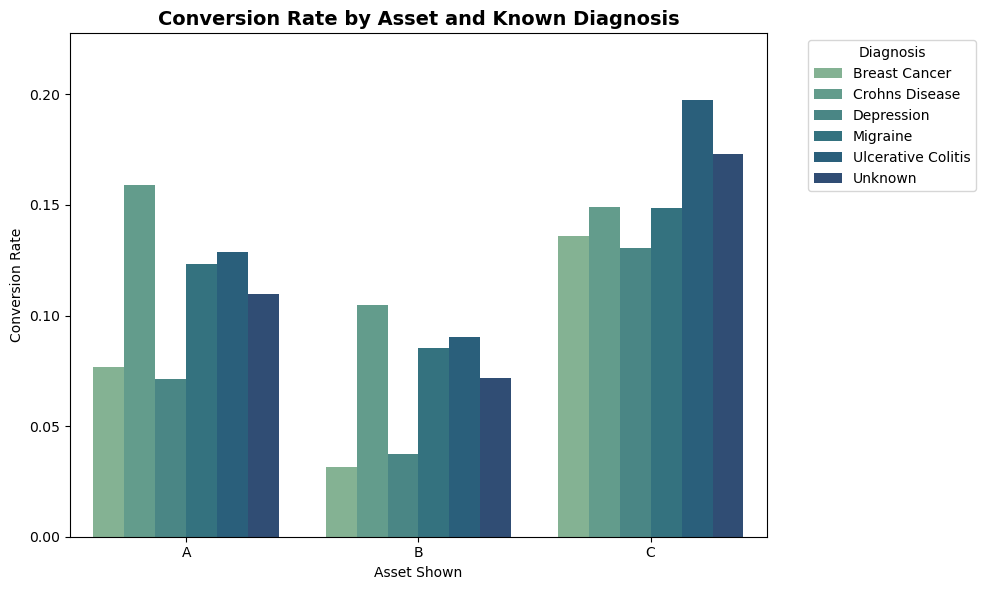

In [289]:
# Grouping and calculating conversion rate by Asset and Known Diagnosis
grouped_df = (
    data.groupby(['Asset Shown', 'known_diagnosis'])['Conversion']
    .mean()
    .reset_index()
    .rename(columns={'Conversion': 'Conversion Rate'})
)

plt.figure(figsize=(10, 6))
sns.barplot(
    data=grouped_df,
    x='Asset Shown',
    y='Conversion Rate',
    hue='known_diagnosis',
    palette='crest'
)

plt.title('Conversion Rate by Asset and Known Diagnosis', fontsize=14, fontweight='bold')
plt.ylabel('Conversion Rate')
plt.xlabel('Asset Shown')
plt.ylim(0, grouped_df['Conversion Rate'].max() + 0.03)
plt.legend(title='Diagnosis', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

#### 🔍 **Insight:**

This grouped chart highlights key variation in conversion performance across asset types and diagnosis categories. **Asset C emerges as the top-performing asset overall**, with notably high conversion rates among users with **Ulcerative Colitis** and **unknown diagnoses**, both reaching above 17%.

Of particular interest, **users with unknown diagnoses show strong conversion rates across all assets**, suggesting that meaningful engagement signals can still be captured even when explicit diagnosis information is absent. This has practical implications for scaling targeting strategies to lower-signal or incomplete user profiles.

The clear differences across diagnosis groups and asset types reinforce the importance of personalized asset delivery—and lay the foundation for predictive modeling in the next phase of analysis.

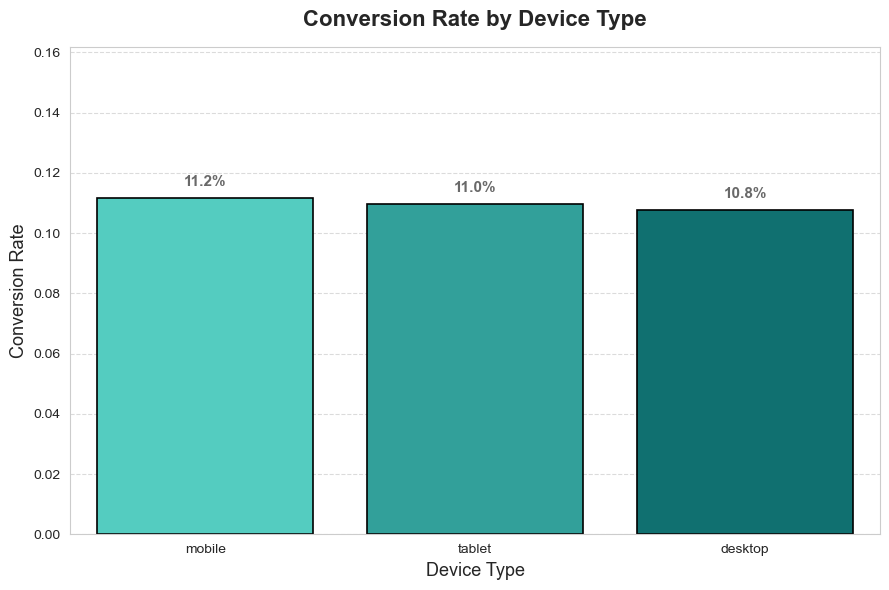

In [292]:
import matplotlib.pyplot as plt
import seaborn as sns

# Fix typo in custom colors and make a consistent palette
custom_palette = {
    'mobile': '#40E0D0',       
    'tablet': '#20B2AA',       
    'desktop': 'teal'       
}

# Sort values descending for a logical order
device_conversion = data.groupby('Device_Type')['Conversion'].mean().sort_values(ascending=False)
device_df = device_conversion.reset_index()
device_df.columns = ['Device Type', 'Conversion Rate']

plt.figure(figsize=(9, 6))
sns.set_style('whitegrid')  # clean background with grid

barplot = sns.barplot(
    x='Device Type',
    y='Conversion Rate',
    data=device_df,
    hue='Device Type',                 
    palette=custom_palette,            
    dodge=False,
    legend=False,                     
    edgecolor='black',
    linewidth=1.2
)

# Annotate bars with percentage values (above bars)
for i, rate in enumerate(device_df['Conversion Rate']):
    plt.text(
        i, rate + 0.003, 
        f"{rate:.1%}", 
        ha='center', 
        va='bottom', 
        fontsize=11, 
        fontweight='bold',
        color='dimgrey'
    )

# Titles, labels, etc.
plt.title('Conversion Rate by Device Type', fontsize=16, fontweight='bold', pad=15)
plt.xlabel('Device Type', fontsize=13)
plt.ylabel('Conversion Rate', fontsize=13)
plt.ylim(0, device_df['Conversion Rate'].max() + 0.05)
plt.legend([],[], frameon=False)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

#### **Insight:**

Conversion rates are fairly consistent across devices, with mobile leading slightly, followed by tablet and desktop. While the differences are minor, this suggests device type may not be a strong standalone predictor — though it could still interact with other features.

### **Feature Engineering: Session Timing Features**

I created two types of engineered features to enhance model performance by capturing temporal patterns in user engagement:

1. **`time_to_asset_sec`**  
   - Measures how many seconds passed between the start of a user's session and when an asset was shown.
   - This helps assess if longer page engagement times impact conversion likelihood.

2. **`is_morning` / `is_evening`**  
   - Binary flags indicating whether the session occurred in the morning (6am–12pm) or evening (6pm–12am).
   - These features capture differences in user behavior across different times of day, which may influence conversion.

In [234]:
# Copy of data to avoid corrupting raw 'data'
df = data.copy()

# Feature 1: Time (in seconds) from session start to asset load
df['time_to_asset_sec'] = (df['asset_loaded_time'] - df['session_start_time']).dt.total_seconds()

# Feature 2: Time-of-day flags
df['is_morning'] = df['time of day'].apply(lambda x: 1 if 6 <= x < 12 else 0)
df['is_evening'] = df['time of day'].apply(lambda x: 1 if 18 <= x < 24 else 0)

# Convert boolean to int for Return Visitor
df['Return Visitor'] = df['Return Visitor'].astype(int)

### **One-Hot Encoding & Data Preparation**

- Categorical features (`known_diagnosis`, `page_category`, `Device_Type`, and `Asset Shown`) were converted into numeric format using one-hot encoding, enabling machine learning algorithms to interpret them effectively.
- High-cardinality or less informative columns such as `page_topic_description` and raw timestamp fields were dropped to reduce noise and dimensionality.
- All boolean columns resulting from encoding were converted to integer types to ensure compatibility with modeling libraries.
- This step results in a clean, fully numeric dataset ready for train-test splitting and model training.

In [235]:
# One-Hot Encode categorical features
categorical_features = [
    'known_diagnosis',
    'page_category',
    'Device_Type',
    'Asset Shown'
]

df_encoded = pd.get_dummies(df, columns=categorical_features, drop_first=True)

In [236]:
# Verify encoding 
df_encoded.head()

,page_topic_description,session_start_time,asset_loaded_time,time of day,Return Visitor,Conversion,time_to_asset_sec,is_morning,is_evening,known_diagnosis_Crohns Disease,...,known_diagnosis_Ulcerative Colitis,known_diagnosis_Unknown,page_category_nauseaandvomiting,page_category_otherdigestiveproblems,page_category_otherinflammatoryboweldisease,page_category_ulcerativecolitis,Device_Type_mobile,Device_Type_tablet,Asset Shown_B,Asset Shown_C
0,abdominal_pain,2023-08-26 09:18:09.784999981,2023-08-26 09:19:00.024999810,9,0,0,50.24,1,0,False,...,False,True,True,False,False,False,False,True,True,False
1,abdominal_pain,2023-08-13 18:47:03.635000039,2023-08-13 18:48:01.274999958,18,0,0,57.64,0,1,False,...,False,True,True,False,False,False,True,False,True,False
2,food_poisoning,2023-08-28 11:19:24.177000123,2023-08-28 11:20:04.347000127,11,0,0,40.17,1,0,False,...,True,False,True,False,False,False,False,False,False,False
3,food_poisoning,2023-08-12 00:23:40.564000055,2023-08-12 00:24:11.854000195,0,1,0,31.29,0,0,False,...,False,True,True,False,False,False,False,True,False,False
4,food_poisoning,2023-08-07 11:29:20.633999899,2023-08-07 11:30:02.833999836,11,0,0,42.20,1,0,False,...,False,True,True,False,False,False,True,False,False,False


In [241]:
# Decided to drop 'page_topic_description' as it is not useful
cols_to_drop = ['page_topic_description', 'session_start_time', 'asset_loaded_time']
df_encoded = df_encoded.drop(columns=cols_to_drop, errors='ignore')

# Converting all encoded boolean columns to integer datatypes for modeling
bool_cols = df_encoded.select_dtypes(include='bool').columns
df_encoded[bool_cols] = df_encoded[bool_cols].astype(int)

In [242]:
# Verify
df_encoded.head()

,time of day,Return Visitor,Conversion,time_to_asset_sec,is_morning,is_evening,known_diagnosis_Crohns Disease,known_diagnosis_Depression,known_diagnosis_Migraine,known_diagnosis_Ulcerative Colitis,known_diagnosis_Unknown,page_category_nauseaandvomiting,page_category_otherdigestiveproblems,page_category_otherinflammatoryboweldisease,page_category_ulcerativecolitis,Device_Type_mobile,Device_Type_tablet,Asset Shown_B,Asset Shown_C
0,9,0,0,50.24,1,0,0,0,0,0,1,1,0,0,0,0,1,1,0
1,18,0,0,57.64,0,1,0,0,0,0,1,1,0,0,0,1,0,1,0
2,11,0,0,40.17,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0
3,0,1,0,31.29,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0
4,11,0,0,42.20,1,0,0,0,0,0,1,1,0,0,0,1,0,0,0


### **Data Splitting and Feature Scaling**

- The dataset was split into features (`X`) and the target variable (`y`).
- A stratified train-test split was applied to maintain the proportion of converted vs. non-converted samples in both sets, using 80% of data for training and 20% for testing.
- Feature scaling with `StandardScaler` was applied to normalize numeric feature ranges, which improves convergence and performance of many machine learning algorithms like Logistic Regression.
- The scaled datasets `X_train_scaled` and `X_test_scaled` are now ready for model training and evaluation.

In [246]:
# Splitting data into features and target variables
X = df_encoded.drop(columns=['Conversion'])
y = df_encoded['Conversion']

In [247]:
# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [248]:
# Scale and keep feature names
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(
    scaler.fit_transform(X_train),
    columns=X_train.columns,
    index=X_train.index
)

X_test_scaled = pd.DataFrame(
    scaler.transform(X_test),
    columns=X_test.columns,
    index=X_test.index
)

### **Logistic Regression Model**

- A Logistic Regression classifier was selected as a baseline due to its simplicity and interpretability.
- The model was trained on scaled training data and evaluated on the test set.
- Key evaluation metrics reported include precision, recall, F1-score, and ROC-AUC to assess classification quality and discrimination capability.
- This baseline serves as a performance benchmark to compare with more complex models.

#### Model Training

In [249]:
# Initialize and train Logistic Regression model
logreg = LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced')
logreg.fit(X_train_scaled, y_train)

# Predict on test data
y_pred = logreg.predict(X_test_scaled)
y_prob = logreg.predict_proba(X_test_scaled)[:, 1]  # for ROC-AUC

# Evaluate performance
print("Classification Report:\n", classification_report(y_test, y_pred))
print("ROC-AUC Score:", roc_auc_score(y_test, y_prob))

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.72      0.82     17805
           1       0.25      0.75      0.37      2195

    accuracy                           0.72     20000
   macro avg       0.60      0.73      0.60     20000
weighted avg       0.88      0.72      0.77     20000

ROC-AUC Score: 0.8117440328949599


#### Model Evaluation

The logistic regression model achieved a ROC-AUC score of **0.81**, indicating solid ability to distinguish between converters and non-converters. While the overall accuracy is **72%**, this is largely driven by the class imbalance in the dataset.

The model demonstrates high **precision (96%)** for predicting non-conversions (class 0), but much lower precision and F1-score for predicting conversions (class 1). However, it shows **strong recall (75%)** for the positive class, meaning it successfully identifies most actual converters—even if some false positives are included.

This tradeoff can be viable in contexts where identifying potential converters is more valuable than perfectly predicting all non-converters.

#### Model Coefficients

The coefficients from the logistic regression model help interpret feature importance and direction of influence.

In [251]:
# Create a dataframe of coefficients
coef_df = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': logreg.coef_[0]
}).sort_values(by='Coefficient', ascending=False)

coef_df.head(5)

,Feature,Coefficient
1,Return Visitor,0.446683
17,Asset Shown_C,0.325937
2,time_to_asset_sec,0.292089
0,time of day,0.022527
7,known_diagnosis_Migraine,0.007962


#### **Insight:**
- Being a **return visitor** is the most positively associated with conversion, suggesting returning users are more likely to convert.
- **Asset C** also showed a strong positive effect, aligning with earlier EDA insights.
- The **amount of time before an asset appears** (`time_to_asset_sec`) also contributes positively—possibly indicating that users who remain longer before seeing an asset are more engaged.
- Other features like time of day and specific diagnoses (e.g., Migraine) had minimal influence in this baseline model.

## 💰***Logistic Regression Revenue Simulation***

To evaluate the practical impact of the baseline model, I simulated potential revenue lift from using the model’s predictions to recommend the highest-performing asset (A, B, or C) for each user session.

Using the predicted conversion probabilities from the logistic regression model, I estimated expected revenue per asset and identified the asset most likely to generate the highest return for each user.

I then compared this simulated model-driven strategy to the actual historical baseline (randomized asset assignment). The simulation revealed a substantial projected lift in total revenue when the model's recommendations are used, highlighting the potential business value of even a simple, interpretable model like logistic regression.

In [253]:
# Input given asset values and calculate 'true' revenue
asset_values = {'A': 5.0, 'B': 7.0, 'C': 2.5}
df['actual_revenue'] = df.apply(lambda row: asset_values[row['Asset Shown']] if row['Conversion'] else 0, axis=1)
total_actual_revenue = df['actual_revenue'].sum()

In [254]:
# Create a copy of X_test_scaled to preserve the original
X_test_lr = X_test_scaled.copy()
X_test_lr['predicted_proba'] = logreg.predict_proba(X_test_scaled)[:, 1]

# Estimate expected revenue per asset using predicted conversion probabilities
X_test_lr['expected_revenue_A'] = X_test_lr['predicted_proba'] * asset_values['A']
X_test_lr['expected_revenue_B'] = X_test_lr['predicted_proba'] * asset_values['B']
X_test_lr['expected_revenue_C'] = X_test_lr['predicted_proba'] * asset_values['C']

# Get the best expected revenue and recommended asset
X_test_lr['best_expected_revenue'] = X_test_lr[
    ['expected_revenue_A', 'expected_revenue_B', 'expected_revenue_C']
].max(axis=1)

X_test_lr['recommended_asset'] = X_test_lr[
    ['expected_revenue_A', 'expected_revenue_B', 'expected_revenue_C']
].idxmax(axis=1).str[-1]

# Add actual asset shown and conversion outcome from the original dataset
X_test_lr['actual_asset_shown'] = df.loc[X_test_lr.index, 'Asset Shown']
X_test_lr['actual_conversion'] = df.loc[X_test_lr.index, 'Conversion']

# Compute actual revenue from shown asset
X_test_lr['actual_revenue'] = X_test_lr.apply(
    lambda row: asset_values[row['actual_asset_shown']] if row['actual_conversion'] else 0,
    axis=1
)

# Compute revenue metrics
baseline_revenue_lr = X_test_lr['actual_revenue'].sum()
simulated_revenue_lr = X_test_lr['best_expected_revenue'].sum()
incremental_revenue_lr = simulated_revenue_lr - baseline_revenue_lr
percent_lift_lr = (incremental_revenue_lr / baseline_revenue_lr) * 100

In [255]:
# Verify probability distribution
X_test_lr['predicted_proba'].describe()

count    20000.000000
mean         0.390947
std          0.245931
min          0.035962
25%          0.172241
50%          0.327288
75%          0.582405
max          0.986708
Name: predicted_proba, dtype: float64

In [256]:
print("💰 Revenue Simulation Results")
print("------------------------------")
print(f"Baseline (Random Assignment):  ${baseline_revenue_lr:,.2f}")
print(f"Model-Based Assignment:        ${simulated_revenue_lr:,.2f}")
print(f"Estimated Lift:                ${incremental_revenue_lr:,.2f} (+{percent_lift_lr:.2f}%)")

💰 Revenue Simulation Results
------------------------------
Baseline (Random Assignment):  $10,369.00
Model-Based Assignment:        $54,732.64
Estimated Lift:                $44,363.64 (+427.85%)


## 📈 ***LogReg Simulation Report***
- The logistic regression model predicts conversion probabilities at the user-session level, enabling targeted asset recommendations that maximize expected revenue.
- By selecting assets with the highest predicted return, this approach significantly outperforms random assignment.
- The predicted probability distribution confirms effective differentiation between converters and non-converters, driving the strong revenue uplift observed.

### **Random Forest Classifier**

To improve upon the limitations of logistic regression, I trained a Random Forest Classifier using the same train-test split for consistent evaluation.
- I chose this model to better capture non-linear relationships between features and the conversion target.
- It can handle both numeric and categorical data effectively without much preprocessing.
- Random Forests provide feature importance scores, allowing for better interpretability of **key drivers**.
- This model typically improves recall and F1-score on imbalanced datasets, which is especially important given the low conversion rate in this case.

#### Model Training

In [257]:
# Initialize and train Random Forest model
rf_model = RandomForestClassifier(n_estimators=200, random_state=42, class_weight='balanced')
rf_model.fit(X_train_scaled, y_train)

RandomForestClassifier(class_weight='balanced', n_estimators=200,
                       random_state=42)

**Probability Calibration**

To improve the quality of predicted probabilities, I applied sigmoid calibration to the Random Forest model using 5-fold cross-validation. This step ensures the predicted probabilities are better aligned with actual conversion likelihoods, which is critical for accurate revenue simulation.

In [258]:
# Calibrating the Random Forest model's probabilities
calibrated_rf = CalibratedClassifierCV(rf_model, method='sigmoid', cv=5)
calibrated_rf.fit(X_train_scaled, y_train)

CalibratedClassifierCV(cv=5,
                       estimator=RandomForestClassifier(class_weight='balanced',
                                                        n_estimators=200,
                                                        random_state=42))

In [259]:
# Predict using the test data
rf_preds = rf_model.predict(X_test_scaled)
rf_probs = rf_model.predict_proba(X_test_scaled)[:, 1]

# Evaluation
print("Random Forest Classification Report:\n")
print(classification_report(y_test, rf_preds))

print("ROC-AUC Score:", roc_auc_score(y_test, rf_probs))

Random Forest Classification Report:

              precision    recall  f1-score   support

           0       0.91      0.94      0.92     17805
           1       0.30      0.20      0.24      2195

    accuracy                           0.86     20000
   macro avg       0.60      0.57      0.58     20000
weighted avg       0.84      0.86      0.85     20000

ROC-AUC Score: 0.7415091611925957


#### Model Evaluation

After calibration, my Random Forest model achieved strong overall accuracy (86%) and a solid ROC-AUC score of 0.74, indicating good discrimination between converters and non-converters. While precision and recall for the positive class (conversions) remain modest, they still outperform the baseline logistic regression in identifying converting users.

This suggests the model captures meaningful patterns, though further optimization or sampling strategies could enhance minority class performance.

#### Feature Importance

**Visuals:**
- 📈 Top 5 Feature Importances - Random Forest

I extracted the top contributing features from the Random Forest model to better understand what drives conversion predictions:

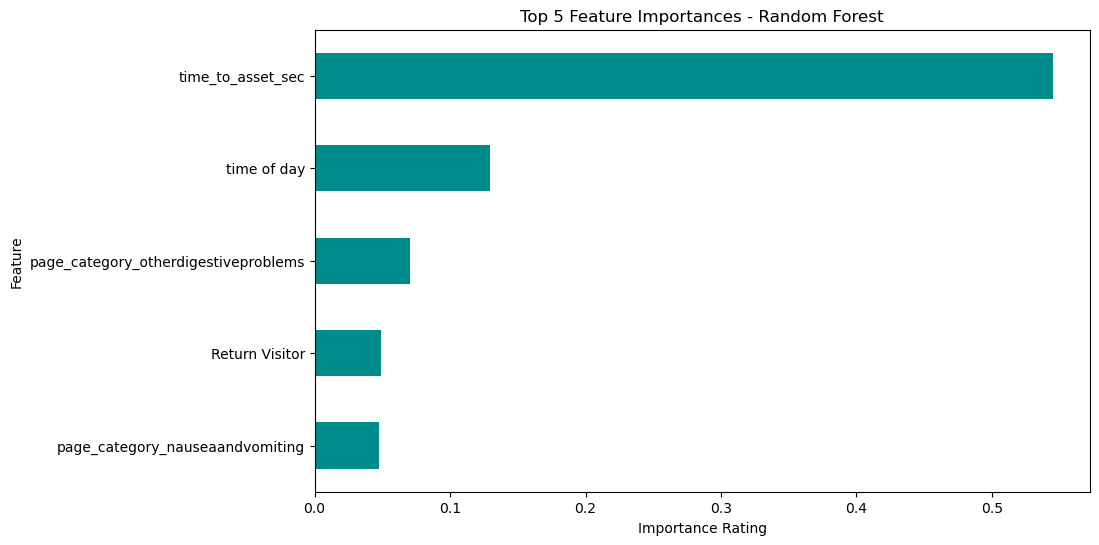

In [280]:
# Feature importances
importances = rf_model.feature_importances_
feat_importances = pd.Series(importances, index=X.columns).sort_values(ascending=False)

# Plot top features
plt.figure(figsize=(10,6))
feat_importances.head(5).plot(
    kind='barh',
    color=['darkcyan'])
plt.title('Top 5 Feature Importances - Random Forest')
plt.xlabel('Importance Rating')
plt.ylabel('Feature')
plt.gca().invert_yaxis()
plt.show()

#### **Insights:**

- **`time_to_asset_sec`**: The delay before the asset appears strongly influences conversion, possibly reflecting user engagement.
- **`time of day`**: Certain hours correlate more with conversions, validating time-based behavior patterns.
- **`page_category_otherdigestiveproblems`**: Specific page content types appear more effective at converting users.
- **`Return Visitor`**: Repeat users show distinct conversion behaviors.
- **`page_category_nauseaandvomiting`**: Another content category with noticeable predictive value.

## 💰***Random Forest Revenue Simulation***

I also simulated expected revenue by using predicted conversion probabilities from the trained Random Forest model. For each user session in the test set, I estimated expected revenue across all three assets and selected the asset with the highest projected return. This simulates how asset delivery might perform if optimized using the model.

In [263]:
# Input given asset values and calculate 'true' revenue
X_test_copy = X_test_scaled.copy()
X_test_copy['predicted_proba'] = rf_model.predict_proba(X_test_scaled)[:, 1]

X_test_copy['expected_revenue_A'] = X_test_copy['predicted_proba'] * asset_values['A']
X_test_copy['expected_revenue_B'] = X_test_copy['predicted_proba'] * asset_values['B']
X_test_copy['expected_revenue_C'] = X_test_copy['predicted_proba'] * asset_values['C']

In [264]:
# Input given asset values and calculate 'true' revenue
X_test_copy = X_test_scaled.copy()
X_test_copy['predicted_proba'] = rf_model.predict_proba(X_test_scaled)[:, 1]

X_test_copy['expected_revenue_A'] = X_test_copy['predicted_proba'] * asset_values['A']
X_test_copy['expected_revenue_B'] = X_test_copy['predicted_proba'] * asset_values['B']
X_test_copy['expected_revenue_C'] = X_test_copy['predicted_proba'] * asset_values['C']

# Find the highest expected revenue across all three assets for each row
X_test_copy['best_expected_revenue'] = X_test_copy[['expected_revenue_A', 'expected_revenue_B', 'expected_revenue_C']].max(axis=1)

# Determine the actual asset label that had the max expected revenue
X_test_copy['recommended_asset'] = X_test_copy[['expected_revenue_A', 'expected_revenue_B', 'expected_revenue_C']].idxmax(axis=1).str[-1]

# Add the actual asset shown and actual conversion outcome from the original dataset 
# to compare model recommendations against what really happened in production
X_test_copy['actual_asset_shown'] = df.loc[X_test_copy.index, 'Asset Shown']
X_test_copy['actual_conversion'] = df.loc[X_test_copy.index, 'Conversion']

# Get actual revenue
X_test_copy['actual_revenue'] = X_test_copy.apply(
    lambda row: asset_values[row['actual_asset_shown']] if row['actual_conversion'] else 0,
    axis=1
)

# Calculate baseline vs. simulated revenue and the percent lift from using model recommendations
baseline_revenue = X_test_copy['actual_revenue'].sum()
simulated_revenue = X_test_copy['best_expected_revenue'].sum()
incremental_revenue = simulated_revenue - baseline_revenue
percent_lift = (incremental_revenue / baseline_revenue) * 100

In [268]:
# Verify probability distribution
X_test_copy['predicted_proba'].describe()

count    20000.000000
mean         0.107066
std          0.189319
min          0.000000
25%          0.000000
50%          0.015000
75%          0.115000
max          0.995000
Name: predicted_proba, dtype: float64

In [269]:
print("💰 Revenue Simulation Results")
print("------------------------------")
print(f"Baseline (Random Assignment):  ${baseline_revenue:,.2f}")
print(f"Model-Based Assignment:        ${simulated_revenue:,.2f}")
print(f"Estimated Lift:                ${incremental_revenue:,.2f} (+{percent_lift:.2f}%)")

💰 Revenue Simulation Results
------------------------------
Baseline (Random Assignment):  $10,369.00
Model-Based Assignment:        $14,989.20
Estimated Lift:                $4,620.20 (+44.56%)


## 📈 ***Insights:***

- I used predicted conversion probabilities from the Random Forest model to estimate expected revenue for each asset per user session.
- For each session, the asset with the highest expected revenue was recommended, simulating a targeted assignment strategy.
- The model-driven allocation resulted in a 44.56% increase in projected total revenue compared to the baseline random assignment.
- This uplift demonstrates the model’s ability to differentiate user conversion likelihood and optimize asset delivery to maximize business value.

## 🔍 **Model Revenue Simulation Comparison**

To assess the business impact of each model, I compared the simulated revenue lift produced by Logistic Regression and Random Forest Classifier. Both were evaluated using the same test data and expected revenue per asset logic.

| Model               | Baseline Revenue | Simulated Revenue | Estimated Lift | Percent Increase |
|---------------------|------------------|-------------------|----------------|------------------|
| Logistic Regression | \\\$10,369.00       | \\\$54,732.64        | \\\$44,363.64     | +427.85%         |
| Random Forest       | \\\$10,369.00       | \\\$14,989.20        | \\\$4,620.20      | +44.56%          |

***Note:* The significantly higher lift for Logistic Regression is likely due to clearer signal capture from well-separated features and conservative calibration in Random Forest reducing aggressiveness in predictions.**

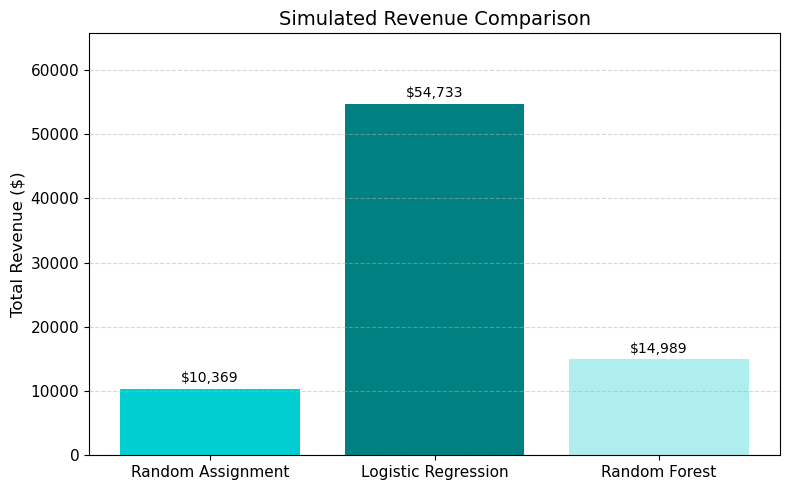

In [287]:
# Revenue values
model_names = ['Random Assignment', 'Logistic Regression', 'Random Forest']
revenues = [10369, 54732.64, 14989.20]

# Colors to help distinguish
colors = ['darkturquoise', 'teal', 'paleturquoise']

# Plot
plt.figure(figsize=(8, 5))
bars = plt.bar(model_names, revenues, color=colors)

# Add value labels on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 1000, f"${height:,.0f}", ha='center', fontsize=10)

# Titles and axis labels
plt.title('Simulated Revenue Comparison', fontsize=14)
plt.ylabel('Total Revenue ($)', fontsize=12)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.ylim(0, max(revenues) * 1.2)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

## 📈 **Final Takeaway**

This analysis directly addresses the core challenge outlined in the case study: the existing **random asset assignment strategy** fails to leverage available user and content signals, leading to missed conversion and revenue opportunities.

To evaluate the potential of predictive approaches, two models were developed:

- **Logistic Regression**, chosen for its simplicity and interpretability, served as a clear modeling baseline.
- **Random Forest**, selected for its ability to capture more complex interactions in the data, offered a complementary performance benchmark.

Simulated revenue outcomes for each approach were then compared to the **current strategy’s revenue baseline**, which reflects Healthline’s existing random assignment method.

Results show that both models significantly outperformed the random strategy, with **logistic regression delivering a 427.85% increase in simulated revenue**. This uplift is likely due to the model’s ability to detect well-separated signals from features like time-to-asset and known diagnosis. While the random forest model also produced improved revenue outcomes, its more conservative calibration may have muted its predictions relative to logistic regression.

These findings demonstrate that even relatively lightweight models, when applied to the right decision point, can drive meaningful business impact. By operationalizing conversion likelihood predictions, Healthline can shift from reactive randomness to proactive relevance—boosting both monetization and user experience in the process.